Running on: cuda
Starting Training...
Epoch 1/12 | Train Loss 1.4588 | Val Loss 1.3493 | IoU 0.3559 | Acc 0.6622
Epoch 2/12 | Train Loss 1.3498 | Val Loss 1.2288 | IoU 0.4040 | Acc 0.7187
Epoch 3/12 | Train Loss 1.2789 | Val Loss 1.1492 | IoU 0.4505 | Acc 0.7546
Epoch 4/12 | Train Loss 1.2346 | Val Loss 1.1348 | IoU 0.4524 | Acc 0.7503
Epoch 5/12 | Train Loss 1.2220 | Val Loss 1.0665 | IoU 0.4938 | Acc 0.7744
Epoch 6/12 | Train Loss 1.1909 | Val Loss 0.9776 | IoU 0.5268 | Acc 0.7922
Epoch 7/12 | Train Loss 1.1825 | Val Loss 1.0134 | IoU 0.5287 | Acc 0.7780
Epoch 8/12 | Train Loss 1.1524 | Val Loss 0.9252 | IoU 0.5562 | Acc 0.8031
Epoch 9/12 | Train Loss 1.1498 | Val Loss 0.9193 | IoU 0.5615 | Acc 0.8088
Epoch 10/12 | Train Loss 1.1382 | Val Loss 0.9655 | IoU 0.5454 | Acc 0.7876
Epoch 11/12 | Train Loss 1.1221 | Val Loss 0.9028 | IoU 0.5789 | Acc 0.8080
Epoch 12/12 | Train Loss 1.1197 | Val Loss 0.9220 | IoU 0.5846 | Acc 0.8093


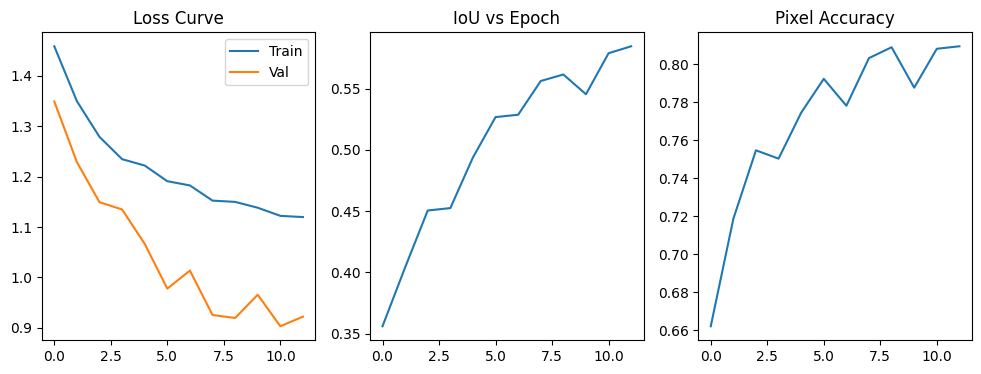

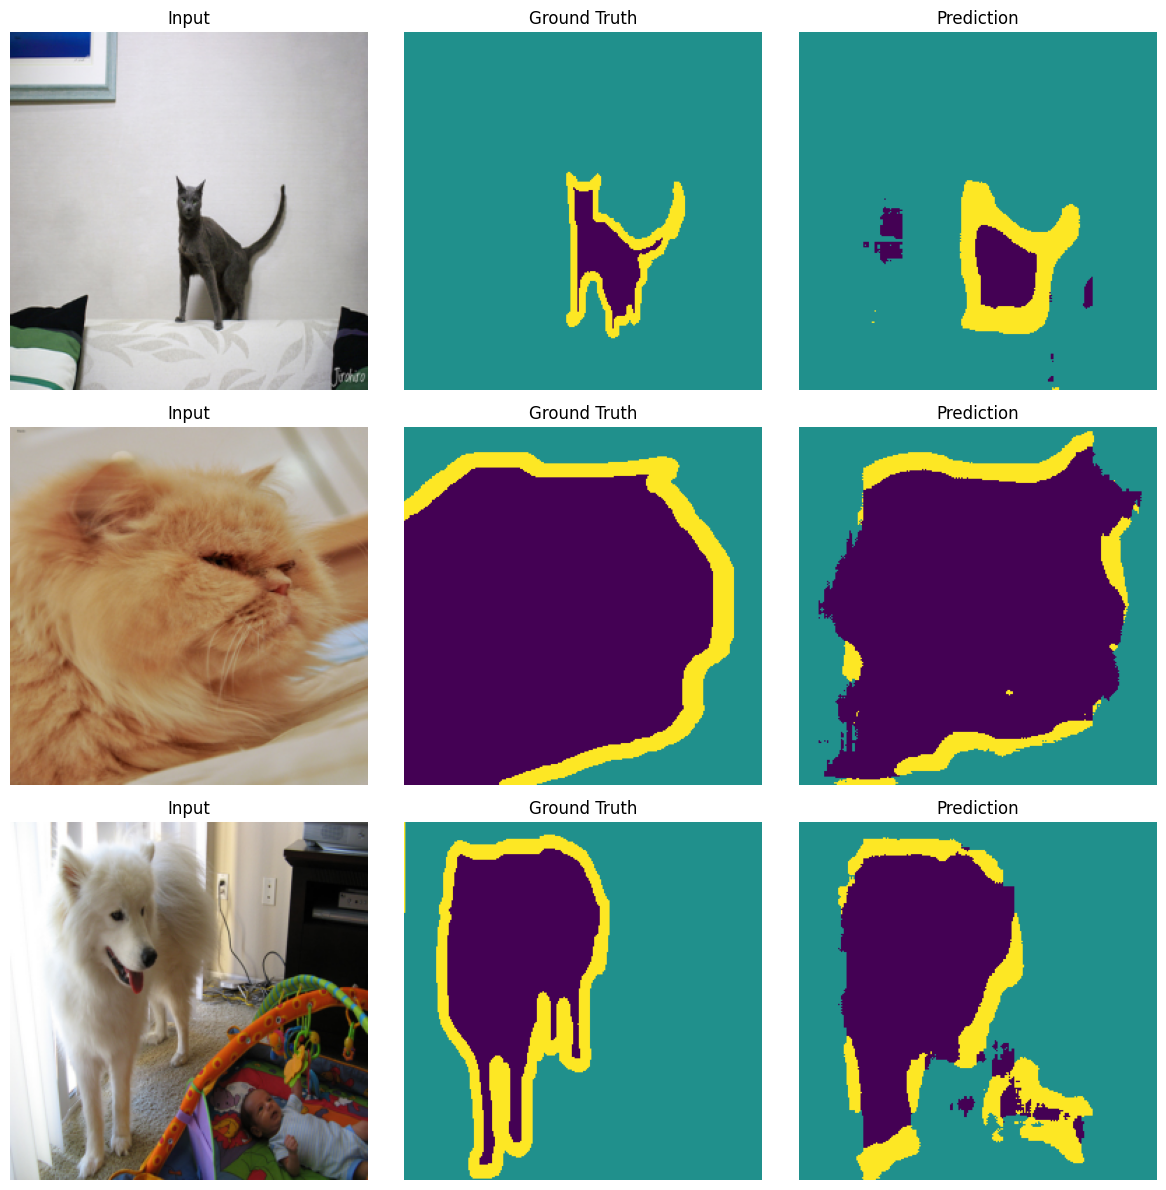

In [ ]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms as T

# ==========================================
# 1. Configuration & Seeding
# ==========================================
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

EXPERIMENT_ID = "EXP_4"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS = 12
BATCH_SIZE = 5
IMG_SIZE = 256
LR = 1e-3

N_CHANNELS = 3
N_CLASSES = 3

print(f"Running on: {DEVICE}")

# ==========================================
# 2. Data Loading & CONTROLLED Augmentation
# ==========================================
train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.4),
    T.RandomRotation(10),               # controlled ±10°
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

mask_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()
])

full_train_ds = OxfordIIITPet(
    root="/content/data",
    split="trainval",
    target_types="segmentation",
    transform=train_tf,
    target_transform=mask_tf,
    download=True
)

full_val_ds = OxfordIIITPet(
    root="/content/data",
    split="trainval",
    target_types="segmentation",
    transform=val_tf,
    target_transform=mask_tf,
    download=False
)

train_len = int(0.8 * len(full_train_ds))
val_len = len(full_train_ds) - train_len

train_ds, _ = random_split(full_train_ds, [train_len, val_len])
_, val_ds = random_split(full_val_ds, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 3. U-Net Architecture
# ==========================================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()
        self.d1 = DoubleConv(n_channels, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.u1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.c1 = DoubleConv(512, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.c2 = DoubleConv(256, 128)

        self.u3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.c3 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.pool(x1))
        x3 = self.d3(self.pool(x2))
        x4 = self.d4(self.pool(x3))

        x = self.u1(x4)
        x = self.c1(torch.cat([x, x3], dim=1))

        x = self.u2(x)
        x = self.c2(torch.cat([x, x2], dim=1))

        x = self.u3(x)
        x = self.c3(torch.cat([x, x1], dim=1))

        return self.out(x)

# ==========================================
# 4. Metrics + Dice Loss
# ==========================================
def dice_loss(pred, target, eps=1e-7):
    pred = F.softmax(pred, dim=1)
    target_oh = F.one_hot(target, N_CLASSES).permute(0,3,1,2).float()

    intersection = (pred * target_oh).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_oh.sum(dim=(2,3))
    dice = (2 * intersection + eps) / (union + eps)

    return 1 - dice.mean()

def iou_score(pred, target):
    pred = torch.argmax(pred, dim=1).view(-1)
    target = target.view(-1)

    ious = []
    for cls in range(N_CLASSES):
        inter = ((pred == cls) & (target == cls)).sum().item()
        union = (pred == cls).sum().item() + (target == cls).sum().item() - inter
        if union > 0:
            ious.append(inter / union)
    return np.mean(ious)

def pixel_accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    return (pred == target).sum().item() / target.numel()

# ==========================================
# 5. Training Loop (CE + Dice)
# ==========================================
model = UNet(N_CHANNELS, N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
ce_loss = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
ious, accs = [], []

print("Starting Training...")
for ep in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        y = y.squeeze(1).long() - 1

        optimizer.zero_grad()
        out = model(x)
        loss = ce_loss(out, y) + dice_loss(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss, val_iou, val_acc = 0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y = y.squeeze(1).long() - 1

            out = model(x)
            val_loss += (ce_loss(out, y) + dice_loss(out, y)).item()
            val_iou += iou_score(out, y)
            val_acc += pixel_accuracy(out, y)

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    ious.append(val_iou / len(val_loader))
    accs.append(val_acc / len(val_loader))

    print(
        f"Epoch {ep+1}/{EPOCHS} | "
        f"Train Loss {train_losses[-1]:.4f} | "
        f"Val Loss {val_losses[-1]:.4f} | "
        f"IoU {ious[-1]:.4f} | "
        f"Acc {accs[-1]:.4f}"
    )

# ==========================================
# 6. GRAPHS (4 plots as requested)
# ==========================================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(ious)
plt.title("IoU vs Epoch")

plt.subplot(1,3,3)
plt.plot(accs)
plt.title("Pixel Accuracy")

plt.show()

# ==========================================
# 7. QUALITATIVE RESULTS (Input / GT / Pred)
# ==========================================
model.eval()
images, masks = next(iter(val_loader))
images = images.to(DEVICE)

with torch.no_grad():
    preds = torch.argmax(model(images), dim=1).cpu()

images = images.cpu()
masks = masks.squeeze(1) - 1

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    axes[i,0].imshow(images[i].permute(1,2,0))
    axes[i,0].set_title("Input")

    axes[i,1].imshow(masks[i], cmap="viridis")
    axes[i,1].set_title("Ground Truth")

    axes[i,2].imshow(preds[i], cmap="viridis")
    axes[i,2].set_title("Prediction")

    for j in range(3):
        axes[i,j].axis("off")

plt.tight_layout()
plt.show()
